# 12-1. 프로젝트: 한영 번역기 만들기

루브릭
아래의 기준을 바탕으로 프로젝트를 평가합니다.
평가문항	상세기준
1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 한국어 포함하여 잘 이루어졌다.	구두점, 대소문자, 띄어쓰기, 한글 형태소분석 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.
2. Attentional Seq2seq 모델이 정상적으로 구동된다.	seq2seq 모델 훈련 과정에서 training loss가 안정적으로 떨어지면서 학습이 진행됨이 확인되었다.
3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.	테스트용 디코더 모델이 정상적으로 만들어져서, 정답과 어느 정도 유사한 영어 번역이 진행됨을 확인하였다.

In [1]:
import pandas
import tensorflow
import matplotlib
import os
import re
import tarfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

print(pandas.__version__)
print(tensorflow.__version__)
print(matplotlib.__version__)

1.3.3
2.6.0
3.4.3


## Step 1. 데이터 다운로드
korean-english-park.train.tar.gz 를 다운로드 받아 한영 병렬 데이터를 확보합니다.

In [2]:
file_path = os.getenv('HOME')+'/aiffel'
print(file_path)

/aiffel/aiffel


In [3]:
archive = tarfile.open("korean-english-park.train.tar.gz")
archive.extractall("dataset")
archive.close()

In [4]:
kor_file = os.path.join(file_path, "dataset/korean-english-park.train.ko")
eng_file = os.path.join(file_path, "dataset/korean-english-park.train.en")

In [5]:
with open(kor_file, "r") as f:
    kor_raw = f.read().splitlines()
    
with open(eng_file, "r") as f:
    eng_raw = f.read().splitlines()
    
dataset = pd.DataFrame(zip(kor_raw, eng_raw), columns=["kor", "eng"])

In [6]:
dataset.sample(5)

,kor,eng
2129,"체첸에 가면 흔적 없이 사라져 버릴 수도 있다""고 말했다.","``There in Chechnya, I could simply disappear.’"
47244,한편 영국 국방부는 헬만 남부지역에서 일어난 로켓 공격으로 2명의 영국 병사가 사망...,"Separately, the British Ministry of Defence an..."
78484,"샌프란시스코에서는, 저스틴 허먼 플라자에서 열리기로 되어 있던 해변가의 폐막식이 안...","In San Francisco, a planned waterfront closing..."
68200,더 내려야 하는 이유,Draft likely to be reduced
5398,성 조지 성당에서의 개인 추도 예배와 매장으로 일반 국민 애도의 날은 끝이 났다.,The private committal service and interment at...


전체 길이, 총 샘플 수

In [7]:
print('korean data size:', len(kor_raw))
print('english data size:', len(eng_raw))

korean data size: 94123
english data size: 94123


In [8]:
raw_corpus = []
for kc, ec in zip(kor_raw, eng_raw):
    raw_corpus.append((kc.lower().strip(), ec.lower().strip()))

In [9]:
cleaned_corpus = list(set(raw_corpus))
print("Data Size:", len(cleaned_corpus))

Data Size: 78941


In [10]:
kor_raw = list(set(kor_raw))
eng_raw = list(set(eng_raw))

중복 제거가 되었다! 그래서 한국어 데이터는 77591개, 그리고 영어 데이터는 75598개가 되었다.

In [11]:
print('korean data size:', len(kor_raw))
print('English data size:', len(eng_raw))

korean data size: 77591
English data size: 75598


제일 긴 데이터 길이는 377이며 평균적인 데이터의 길이는 60이다.

Korean data size :377
Average of Korean data size :64.53810364604142


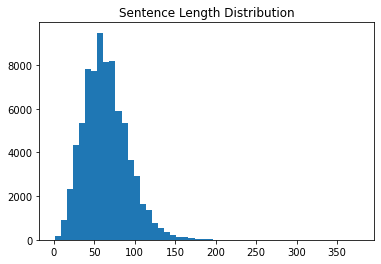

In [12]:
print('Korean data size :{}'.format(max(len(l) for l in kor_raw)))
print('Average of Korean data size :{}'.format(sum(map(len, kor_raw))/len(kor_raw)))

plt.hist([len(s) for s in kor_raw], bins=50)
plt.title("Sentence Length Distribution")
plt.show()

길이가 1인 데이터에 '가 있다.. 노이즈가 있는 데이터인 것을 알 수 있다.

In [13]:
def check_sentence_with_length(kor_raw, length):
    count = 0
    
    for sen in kor_raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(kor_raw, 1)

’


데이터 길이를 잘라내보자.

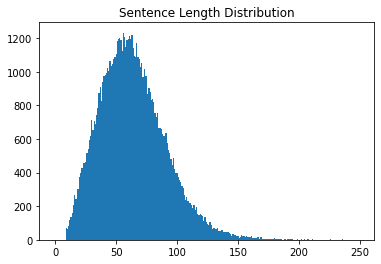

In [14]:
#max_len = 250
#min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
#filtered_corpus_kor = [s for s in kor_raw if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
#sentence_length = np.zeros((max_len), dtype=int)

#for sen in filtered_corpus_kor:
#    sentence_length[len(sen)-1] += 1

#plt.bar(range(max_len), sentence_length, width=1.0)
#plt.title("Sentence Length Distribution")
#plt.show()

영어 데이터도 확인해보자

English data size :605
Average of English data size :134.5200534405672


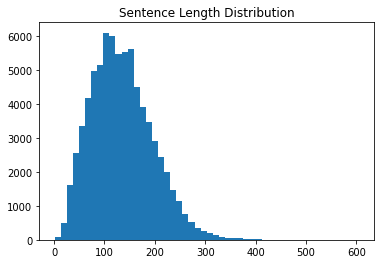

In [15]:
print('English data size :{}'.format(max(len(l) for l in eng_raw)))
print('Average of English data size :{}'.format(sum(map(len, eng_raw))/len(eng_raw)))

plt.hist([len(s) for s in eng_raw], bins=50)
plt.title("Sentence Length Distribution")
plt.show()

역시나 노이즈가 많다.

In [16]:
check_sentence_with_length(eng_raw, 1)

"
·
.


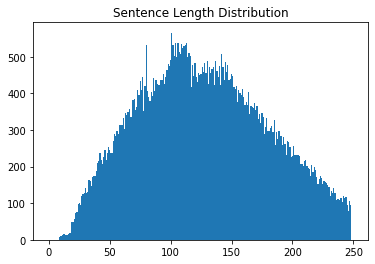

In [17]:
#max_len = 250
#min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
#filtered_corpus_eng = [s for s in eng_raw if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
#sentence_length = np.zeros((max_len), dtype=int)

#for sen in filtered_corpus_eng:
#    sentence_length[len(sen)-1] += 1

#plt.bar(range(max_len), sentence_length, width=1.0)
#plt.title("Sentence Length Distribution")
#plt.show()

In [18]:
#print(len(filtered_corpus_kor))

77388


In [19]:
#print(len(filtered_corpus_eng))

72584


불필요한 데이터들을 잘라내었다. 이제 노이즈를 제거해주자.

In [41]:
import re

def preprocess_sentence(sentence, is_english=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,가-힣ㄱ-ㅎㅏ-ㅣ]+", " ", sentence) 

    sentence = sentence.strip()

    if is_english:
        sentence = '<start> ' + sentence

    if is_english:
        sentence += ' <end>'
    
    return sentence

kor_corpus, eng_corpus 리스트를 만들어주고 중복 제거한 cleaned_corpus를 문장으로 보여지게 해준다!

In [21]:
kor_corpus = []
eng_corpus = []

for sentence in cleaned_corpus:
    ko_sen, en_sen = sentence
    kor_corpus.append(preprocess_sentence(ko_sen))
    eng_corpus.append(preprocess_sentence(en_sen, is_english=True))
    
print("Korean:", kor_corpus[100])
print("English:", eng_corpus[100])


Korean: 미국 국무성 대변인 톰 케이시는 버마 정권과 그 활동에 대한 우리의 우려를 매우 솔직하게 논의한 자리였다 고 밝혔다 .
English: <start> us state department spokesman tom casey said it was a very frank discussion of our concerns about the regime , about its behavior . <end>


결과가 나쁘지 않다! 여기까지 오는데도 정말 머나먼 과정이였다.. 전처리 어떤 부분이 문제인진 모르겠으나 corpus를 언제 합쳐서 전처리하냐에 따라 문장이 뒤죽박죽 섞여서 출력되기도 했다..

In [22]:
kor_corpus[:10]

['이밖에 이슬라마바드와 라왈비니에서는 시위 현장으로 가던 변호사 명이 경찰에 체포됐다 .',
 '중국에는 인구 백만 이상의 도시들이 개 있다 .',
 '양측이 핵시설 불능화를 위한 실무 수준의 단계까지 합의를 마쳤다고 , 이름이 밝혀지지 않은 북한 외무부 대변인이 국영 북한 중앙 통신사에 전했다 .',
 '그러나 로마가 멋진 승리를 위한 경기를 계속 이끌어 나가면서 첼시는 분에 데코가 경고로 퇴장한 조건에서 결코 전세를 바꿀 수 없었다 .',
 '한나라당에서는 또한 노대통령의 강연을 주최한 단체인 참여정부 평가 포럼이 선거 운동 이전에 구성되는 것이 법적으로 금지된 선거 운동 단체라고 주장했다 .',
 '무샤라프 대통령은 군중 명이 사망한 자살폭탄 테러 후에도 부토 전 총리가 타고 있던 차량 내부 사람은 아무도 다치지 않았다고 말했다 .',
 '이것의 중력은 행성들이 궤도를 벗어나지 않도록 만들어준다 .',
 '고객이 제품을 반납할 경우 환불 해줄 예정이다 .',
 '한편 본즈는 현재 약물복용 의혹을 받고 있다 .',
 '후앙 리는 일 향강에서 강의 흐름을 따라 . km이상 되는 거리를 수영했다 .']

In [23]:
eng_corpus[:10]

['<start> another lawyers were arrested in islamabad and rawalbini as they gathered for a demonstration , police said . <end>',
 '<start> there are cities in china with populations over m . <end>',
 '<start> the two sides agreed on working level steps to disable the nuclear facilities , an unnamed spokesman for north korea s foreign ministry told the state run korean central news agency . <end>',
 '<start> but they never looked capable of getting back on even terms as roma held on for a famous victory , made easier by the sending off on minutes of deco , who was sent off for a second yellow card . <end>',
 '<start> the party also claimed that the group that hosted roh s lecture , the participatory government evaluation forum , was a campaign organization that the election law prohibits from being formed prior to the beginning of the campaign . <end>',
 '<start> musharraf pointed out that no one else in the vehicle was injured when gunshots rang out , followed by suicide blast that kill

In [24]:
len(kor_corpus)

78941

In [25]:
len(eng_corpus)

78941

## Step 2. 데이터 정제

토큰의 길이가 40 이하인 데이터를 선별하여 eng_corpus와 kor_corpus를 각각 구축하였다.

In [26]:
max_len = 40

kor_corpus_cut = []
eng_corpus_cut = []

for kor_sen, eng_sen in zip(kor_corpus, eng_corpus):
    if len(kor_sen) <= max_len:
        kor_corpus_cut.append(kor_sen)
        eng_corpus_cut.append(eng_sen)
        
kor_corpus = kor_corpus_cut
eng_corpus = eng_corpus_cut

16234로 더 줄어들었다!

In [27]:
len(kor_corpus)

16234

In [28]:
len(eng_corpus)

16234

## Step 3. 데이터 토큰화

앞서 정의한 tokenize() 함수를 사용해 데이터를 텐서로 변환하고 각각의 tokenizer를 할당했다.

In [29]:
import tensorflow as tf
from konlpy.tag import Mecab

mecab = Mecab()

def tokenize(corpus, is_english, num_words=10000):
    if is_english:
        tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', num_words=num_words)
        tokenizer.fit_on_texts(corpus)

        tensor = tokenizer.texts_to_sequences(corpus)

        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

        return tensor, tokenizer
    

    morphs_corpus = [" ".join(mecab.morphs(sen)) for sen in corpus]
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', num_words=num_words)
    tokenizer.fit_on_texts(morphs_corpus)

    tensor = tokenizer.texts_to_sequences(morphs_corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [30]:
_, all_kor_tokenizer = tokenize(kor_corpus, False, None)
_, all_eng_tokenizer = tokenize(eng_corpus, True, None)

print(len(all_kor_tokenizer.index_word) + 1)
print(len(all_eng_tokenizer.index_word) + 1)

17365
16850


In [31]:
kor_tensor, kor_tokenizer = tokenize(kor_corpus, False)
eng_tensor, eng_tokenizer = tokenize(eng_corpus, True)

## Step 4. 모델 설계

Attention 기반 Seq2seq 모델을 설계했다.

In [32]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1) #com(combine)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        #print("[h_enc]shape:", h_enc.shape)
        # h_dec shape: [batch x units]
        #print("[h_dec]shape:", h_dec.shape)

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn


In [33]:
# Encoder
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units, return_sequences=True)
        
    def call(self, x):
        # Embedding
        out = self.embedding(x)
        
        # GRU layer
        out = self.gru(out)
        
        return out

In [34]:
# Decoder
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       recurrent_dropout=0.4,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn


In [35]:
BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(kor_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(eng_tokenizer.index_word) + 1

units         = 128
embedding_dim = 128

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 40

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)


Encoder Output: (64, 40, 128)
Decoder Output: (64, 16850)
Decoder Hidden State: (64, 128)
Attention: (64, 40, 1)


In [36]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [37]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss


## Step 5. 훈련하기

In [38]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tensorflow as tf

# evaluate
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((eng_tensor.shape[-1], kor_tensor.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    sentence = " ".join(mecab.morphs(sentence))
    inputs = kor_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=kor_tensor.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([eng_tokenizer.word_index['<start>']], 0)

    for t in range(eng_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += eng_tokenizer.index_word[predicted_id] + ' '

        if eng_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention

# Attention Map을 시각화
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

# translate
def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))


100%|██████████| 254/254 [03:21<00:00,  1.26it/s]
/tmp/ipykernel_293/3540374676.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_293/3540374676.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


Input: 오바마 는 대통령 이 다 .
Predicted translation: <end> 


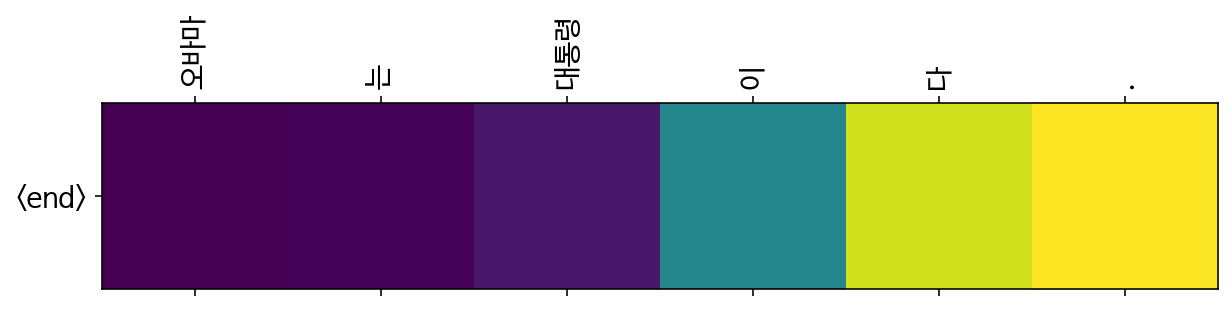

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: <end> 


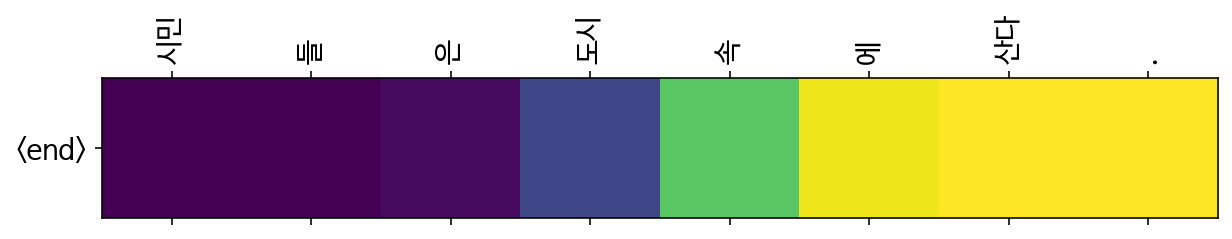

Input: 커피 는 필요 없 다 .
Predicted translation: <end> 


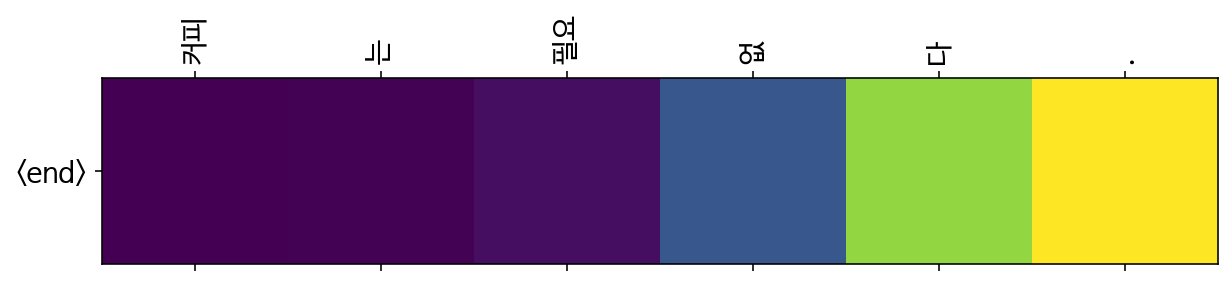

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: <end> 


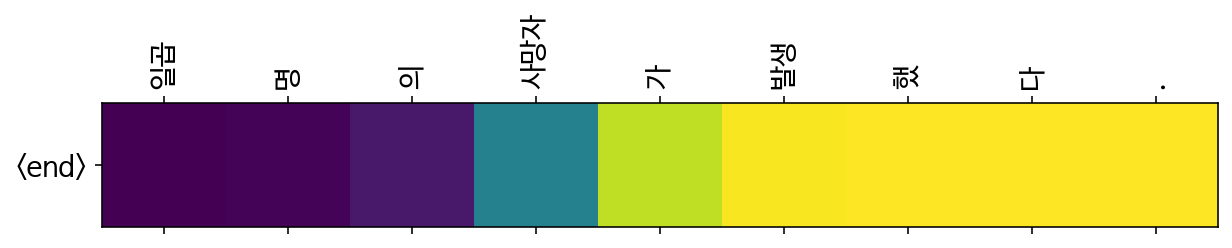

100%|██████████| 254/254 [00:47<00:00,  5.33it/s]


Input: 오바마 는 대통령 이 다 .
Predicted translation: <end> 


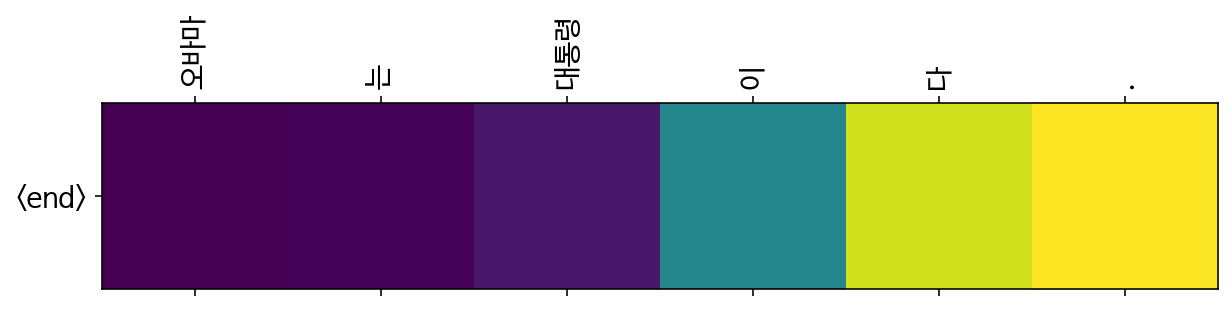

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: <end> 


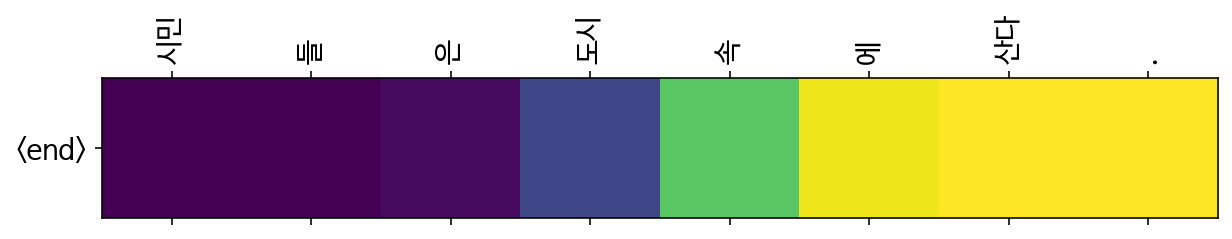

Input: 커피 는 필요 없 다 .
Predicted translation: <end> 


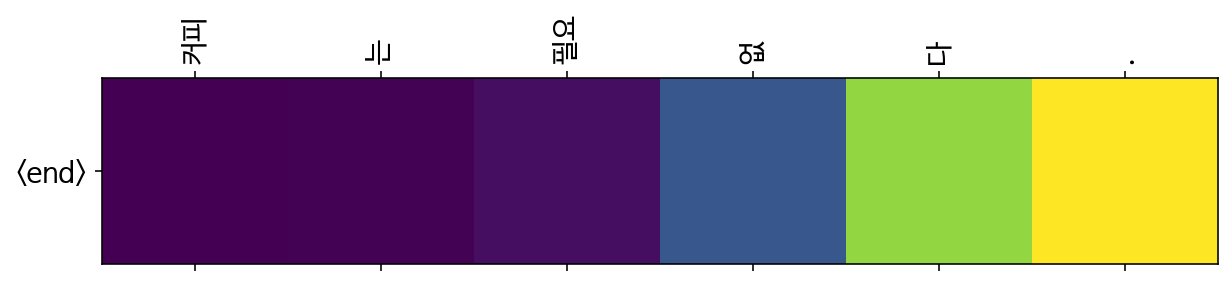

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: <end> 


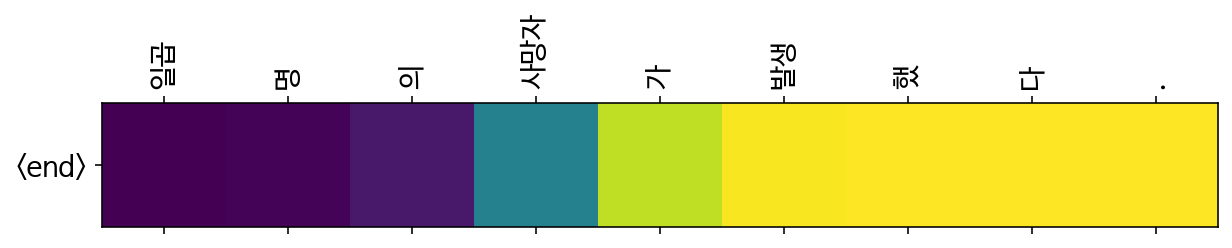

100%|██████████| 254/254 [00:48<00:00,  5.24it/s]


Input: 오바마 는 대통령 이 다 .
Predicted translation: <end> 


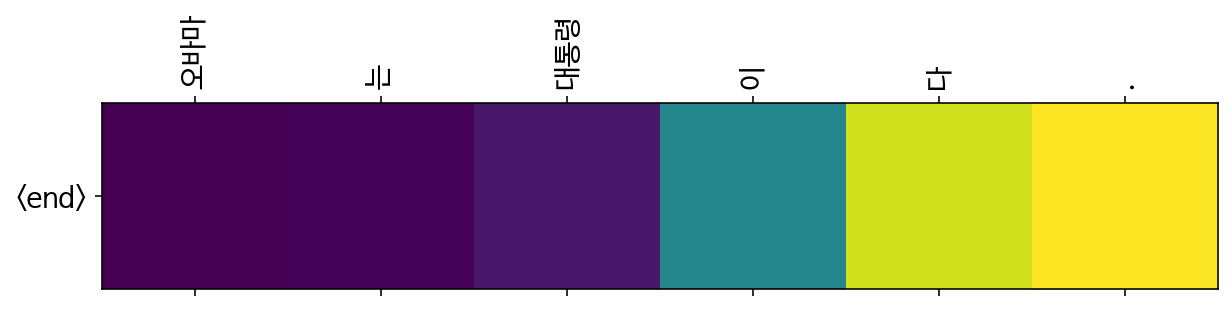

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: <end> 


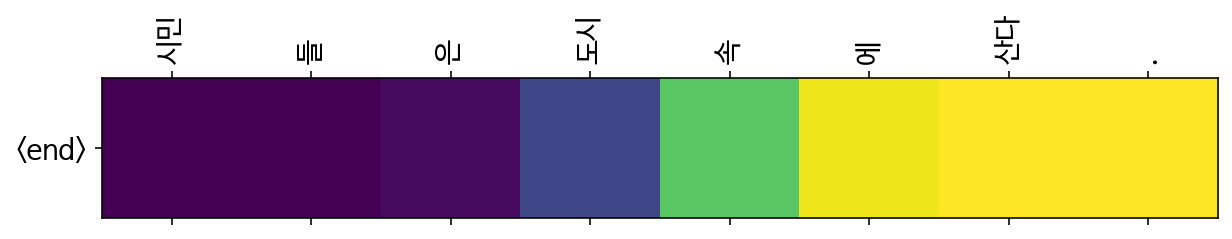

Input: 커피 는 필요 없 다 .
Predicted translation: <end> 


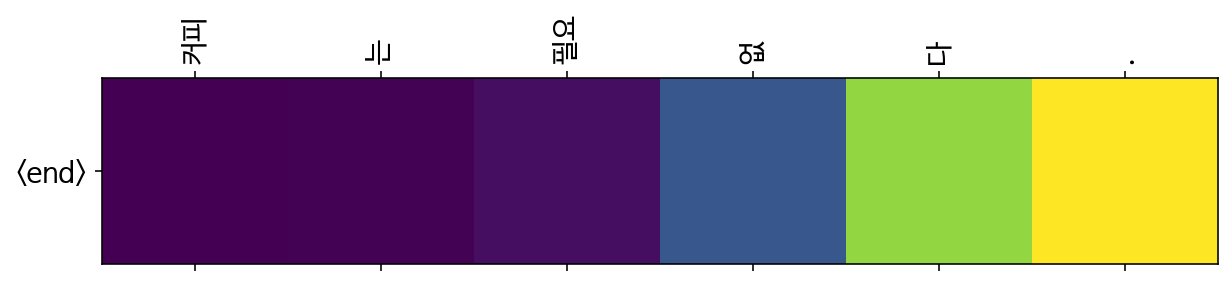

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: <end> 


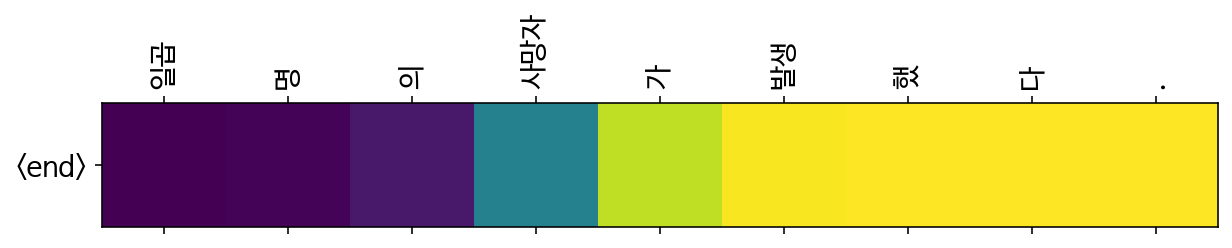

 12%|█▏        | 31/254 [00:06<00:44,  4.98it/s]


KeyboardInterrupt: 

In [40]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 10
loss_history = []

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, kor_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(kor_tensor[idx:idx+BATCH_SIZE],
                                eng_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                eng_tokenizer)
    
        total_loss += batch_loss
        
    loss_history.append(total_loss.numpy() / len(idx_list))
    translate("오바마는 대통령이다.", encoder, decoder)
    translate("시민들은 도시 속에 산다.", encoder, decoder)
    translate("커피는 필요 없다.", encoder, decoder)
    translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

중복 제거하고 데이터 길이를 잘라준 후 한국어 corpus와 영어 corpus를 합치고 진행했더니 데이터들이 뒤죽박죽 섞여서 the만 나오는 결과를 확인할 수 있었다. 그래서 중복 제거를 하기 전에 kor_raw와 eng_raw를 합쳐준 후 중복 제거하고 데이터 길이를 잘라줬더니 이번에는 'end'만 출력되었다.... 도대체 뭐가 문제였을까 해서 혹시 데이터 길이를 한국어와 영어 각각 다른 값으로 잘라줘서 학습에 문제가 생긴거 같아서 길이를 똑같이 맞춰서 잘라주고 학습시켜보았다. 그랬더니 KeyboardInterrupt: 에러가 떴다.. 멘탈이 좋아지지 않아서 프로젝트를 여기서 마무리 시켰다.. 준님 코드 아니였으면 프로젝트 영영 했을 거 같다.... 정말 너무 어렵다ㅠㅠ 